In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install qdrant-client
!pip install torchvision torch

In [30]:
import os
import clip
import json
import spacy
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from qdrant_client import QdrantClient
from google.colab import drive, userdata
from qdrant_client.models import Distance, VectorParams, PointStruct

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
with open("/content/drive/MyDrive/ii/data.json", 'r') as f:
  data = json.load(f)

Data = data[:5000]
Data[0]

{'type': 'chair',
 'color': 'gold',
 'prompt': 'Professional product photography of a industrial gold chair, made of plywood, modular shape, featuring mesh back, conference in mind, luxury price range. Pure white background, studio lighting, commercial product photography, 8k, ultra detailed, centered composition, professional furniture catalog style',
 'img_path': '/content/drive/MyDrive/Colab Notebooks/data/image_0.jpg'}

In [16]:
Data[0]["prompt"]

'Professional product photography of a industrial gold chair, made of plywood, modular shape, featuring mesh back, conference in mind, luxury price range. Pure white background, studio lighting, commercial product photography, 8k, ultra detailed, centered composition, professional furniture catalog style'

In [6]:
Data[1]["prompt"]

'Professional product photography of a traditional red bed, made of upholstered, featuring upholstered headboard, kids room in mind. Pure white background, studio lighting, commercial product photography, 8k, ultra detailed, centered composition, professional furniture catalog style'

In [7]:
Data[3022]["prompt"]

'Professional product photography of a basic purple bed, made of oak, featuring flat base, bedroom in mind. Pure white background, studio lighting, commercial product photography, 8k, ultra detailed, centered composition, professional furniture catalog style'

In [9]:
text1 = "Professional product photography of a"
text2 = "Pure white background, studio lighting, commercial product photography, 8k, ultra detailed, centered composition, professional furniture catalog style"

cnt = 0
for raw in Data:
  if raw["prompt"].startswith(text1) and raw["prompt"].endswith(text2):
    cnt += 1
print(cnt)

5000


In [19]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    """
    Use spaCy to preprocess the input text:
    - Lowercasing
    - Removing stopwords, punctuation, and non-alphabetic tokens
    - Lemmatization
    """
    text = text.replace(text1, "")
    text = text.replace(text2, "")
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

In [20]:
preprocess_text(Data[0]["prompt"])

'industrial gold chair plywood modular shape feature mesh conference mind luxury price range'

In [21]:
for raw in Data:
  raw["prompt"] = preprocess_text(raw["prompt"])

Data[0]["prompt"]

'industrial gold chair plywood modular shape feature mesh conference mind luxury price range'

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/32", device=device)

In [26]:
text_data = [raw["prompt"] for raw in Data]

In [27]:
text_tokens = clip.tokenize(text_data).to(device)
with torch.no_grad():
  text_features = model.encode_text(text_tokens)
  text_features = F.normalize(text_features, p=2, dim=-1)

In [42]:
QDRANT_HOST = userdata.get("QDRANT_HOST")
QDRANT_API_KEY = userdata.get("QDRANT_API_KEY")
client = QdrantClient(
    url=QDRANT_HOST,
    api_key=QDRANT_API_KEY,
    timeout=60.0
)

In [32]:
collection_name = "furniture_descriptions"

client.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=512, distance=Distance.COSINE)
)

<ipython-input-32-ad1d36b12738>:3: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [36]:
for chunk in range(0, len(text_data), 500):
  points = []
  text_batch = text_data[chunk:chunk+500]
  feature_batch = text_features[chunk:chunk+500]

  for i, (text, feature) in enumerate(zip(text_batch, feature_batch)):
    points.append(
        PointStruct(id=i+chunk, vector=feature.tolist(), payload={"text": text})
    )

  client.upsert(collection_name=collection_name, points=points)

<ipython-input-45-9fbe19230ce3>:7: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


score: 0.7988999


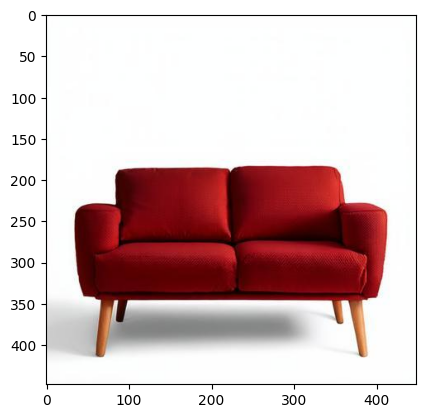

score: 0.79783416


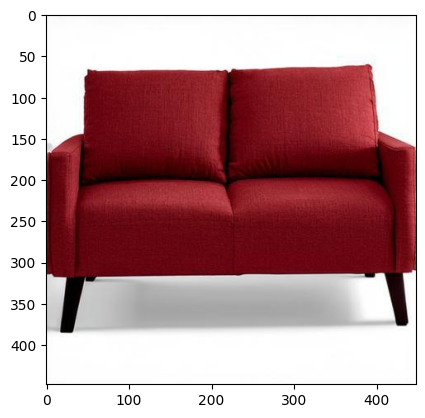

score: 0.79566514


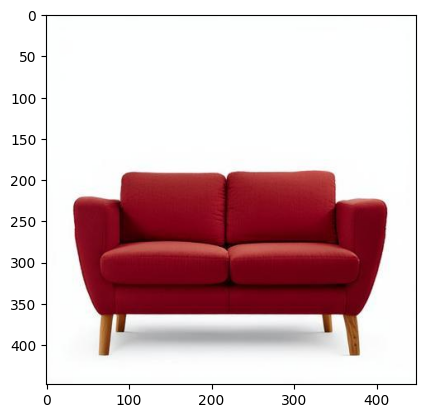

score: 0.7923651


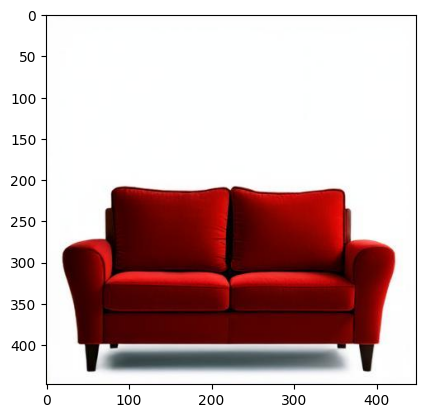

score: 0.7908497


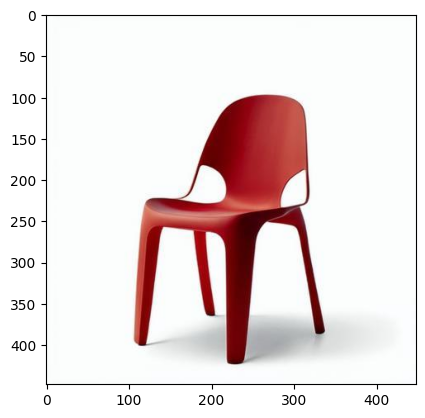

score: 0.787247


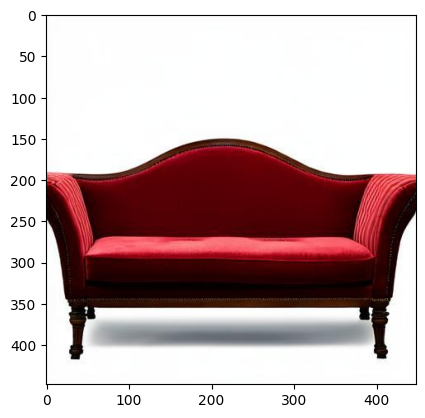

score: 0.77993214


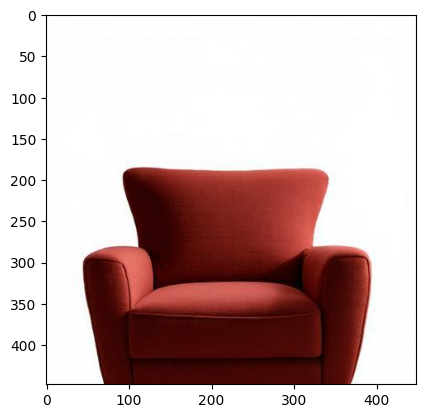

score: 0.7753016


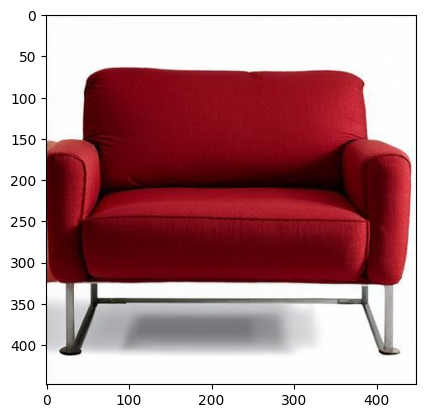

score: 0.774416


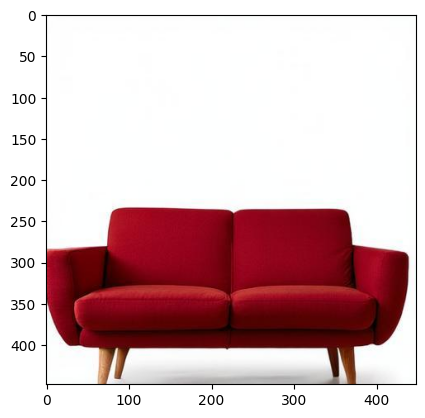

score: 0.7729696


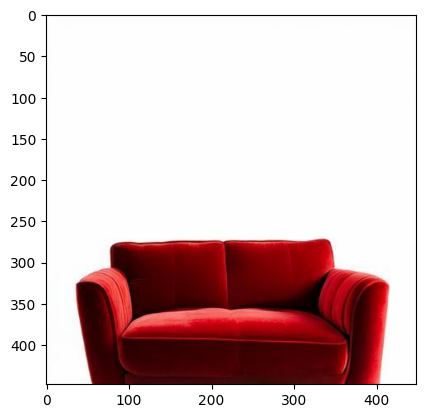

In [45]:
query = "a small red couch with wooden legs"
tokens = clip.tokenize([query]).to(device)
with torch.no_grad():
    query_vec = model.encode_text(tokens)[0]
    query_vec = F.normalize(query_vec, p=2, dim=-1)

search_result = client.search(
    collection_name=collection_name,
    query_vector=query_vec.tolist(),
    limit=10
)

for hit in search_result:
  idx = hit.id
  score = hit.score

  print(f"score: {score}")
  plt.imshow(Image.open(Data[idx]['img_path']))
  plt.show()

<ipython-input-49-6443493a1c5a>:7: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


score: 0.81158596


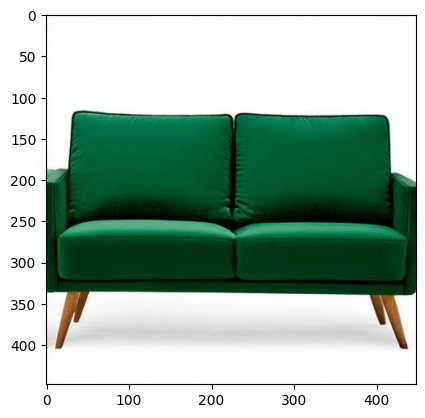

score: 0.8100648


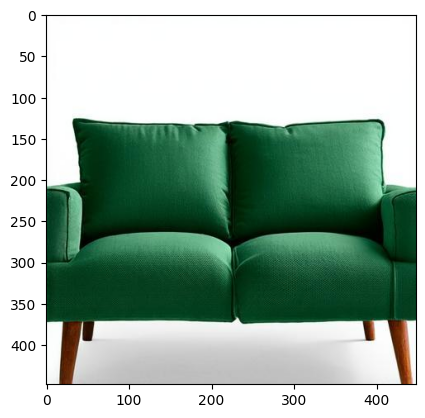

score: 0.80094576


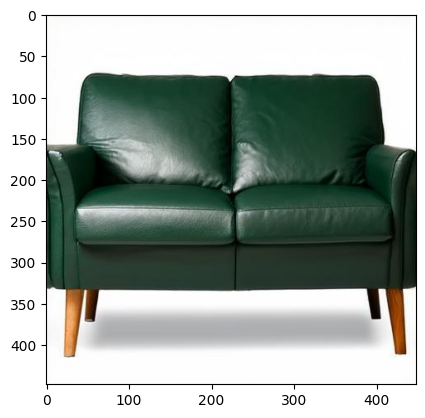

score: 0.79581344


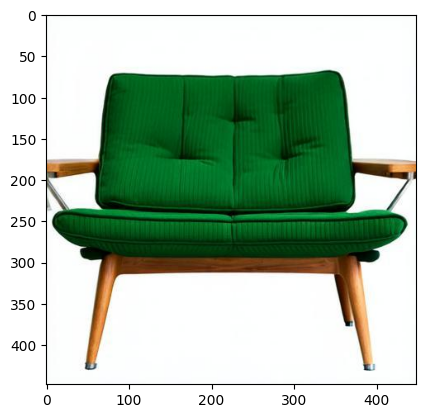

score: 0.7908127


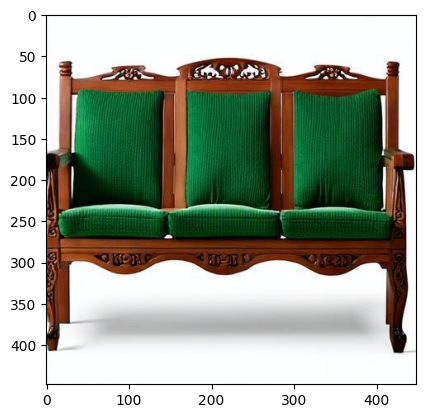

score: 0.78949153


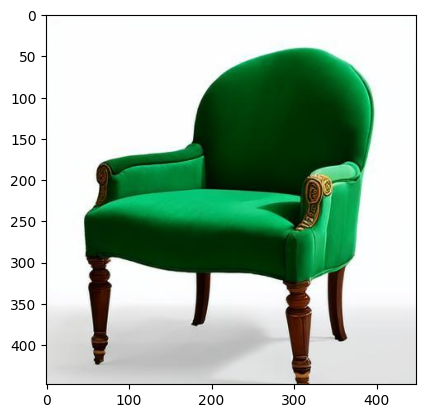

score: 0.7878072


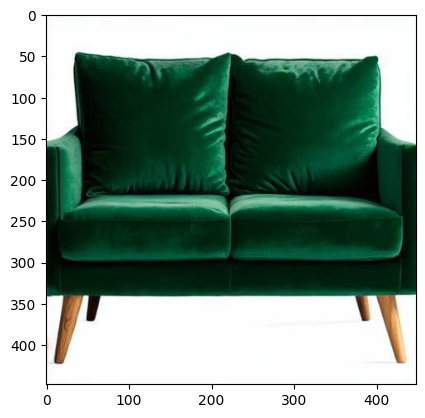

score: 0.771033


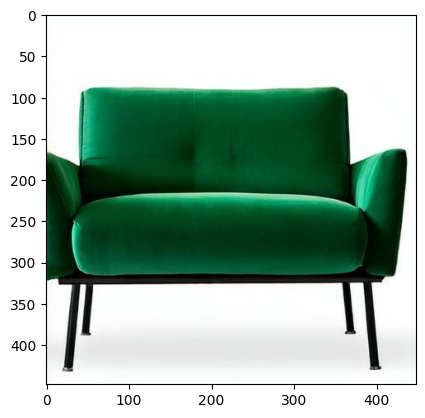

score: 0.7679056


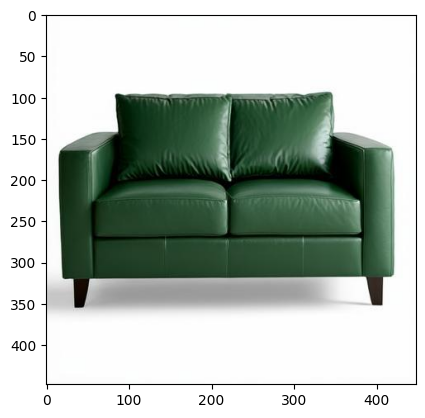

score: 0.7649773


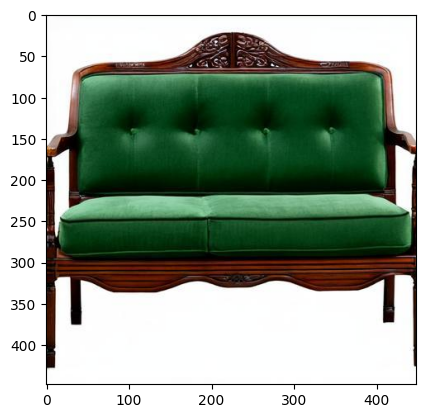

In [49]:
query = "a small green couch with wooden legs"
tokens = clip.tokenize([query]).to(device)
with torch.no_grad():
    query_vec = model.encode_text(tokens)[0]
    query_vec = F.normalize(query_vec, p=2, dim=-1)

search_result = client.search(
    collection_name=collection_name,
    query_vector=query_vec.tolist(),
    limit=10
)

for hit in search_result:
  idx = hit.id
  score = hit.score

  print(f"score: {score}")
  plt.imshow(Image.open(Data[idx]['img_path']))
  plt.show()